In [48]:
import os
import zipfile
import cdsapi
import xarray as xr

import numpy as np

from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import brentq

from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import gc


MAPEH1 = (22.600338,114.545072)
MAPEH2 = (22.608738,114.548871)
MAPEH3 = (22.614854,114.540537)

MAPzEH1 = -21.79
MAPzEH2 = 4.44
MAPzEH3 = 10.07

class ERADailyModel:
    northBoundary = 40
    southBoundary = 0
    westBoundary  = 100
    eastBoundary  = 130
    areaRequest = [northBoundary,westBoundary,southBoundary,eastBoundary]


    def __init__(self, dayRequest, monthRequest,yearRequest):
        self.dayRequest = dayRequest
        self.monthRequest = monthRequest
        self.yearRequest = yearRequest

        '''
        给定数据的存储位置, zip文件保存在当前目录下/data/子目录，以时间命名。解压缩文件放在时间命名的文件夹下。
        '''
        self.dateStr = f'{yearRequest}{monthRequest}{dayRequest}'
        self.zipPath  = os.getcwd() + f'/data/{self.dateStr}.zip'
        self.dataPath = os.getcwd() + f'/data/{self.dateStr}/'
        self.geopDataPath = self.dataPath + 'geopotential_stream-oper_daily-mean.nc' # geop文件默认名称
        self.tempDataPath = self.dataPath + 'temperature_0_daily-mean.nc'            # temp文件默认名称

        try: 
            geopDataSet = xr.open_dataset(self.geopDataPath,engine='netcdf4')
            tempDataSet = xr.open_dataset(self.tempDataPath,engine='netcdf4')
        except FileNotFoundError:
            dataset = "derived-era5-pressure-levels-daily-statistics"
            request = {
                "product_type": "reanalysis",
                "variable": [
                "geopotential",
                "temperature"
            ],
                "year": f"{yearRequest}",
                "month": [f"{monthRequest}"],
                "day": [f"{dayRequest}"],
                "pressure_level": [
                    "1", "2", "3",
                    "5", "7", "10",
                    "20", "30", "50",
                    "70", "100", "125",
                    "150", "175", "200",
                    "225", "250", "300",
                    "350", "400", "450",
                    "500", "550", "600",
                    "650", "700", "750",
                    "775", "800", "825",
                    "850", "875", "900",
                    "925", "950", "975",
                    "1000"
                    ],
                "daily_statistic": "daily_mean",
                "time_zone": "utc+08:00",
                "frequency": "6_hourly",
                "area": self.areaRequest
            }
            client = cdsapi.Client()
            client.retrieve(dataset, request).download(self.zipPath)

            with zipfile.ZipFile(self.zipPath,'r') as z:
                fileList = z.namelist()
                print(f'{fileList}')
                os.mkdir(os.getcwd()+f'/data/{self.dateStr}')
                z.extractall(os.getcwd()+f'/data/{self.dateStr}/')
                geopDataSet = xr.open_dataset(os.getcwd()+f'/data/{self.dateStr}/{fileList[0]}',engine='netcdf4')
                tempDataSet = xr.open_dataset(os.getcwd()+f'/data/{self.dateStr}/{fileList[1]}',engine='netcdf4')

            try:
                os.remove(self.zipPath)
            except FileNotFoundError:pass

        self.temperature = tempDataSet['t'].squeeze()
        self.altitude = geopDataSet['z'].squeeze()/9.8066
        self.pressure = self.temperature['pressure_level'].squeeze()*1e2 # pa
        self.longitude = self.temperature['longitude'].squeeze()
        self.latitude  = self.temperature['latitude'].squeeze()

        R = 8.314 #J/(mol*K)
        M_air = 0.02896 #kg/mol
        self.density = self.pressure * M_air /(R * self.temperature)

        self.tempInterp = RegularGridInterpolator((self.pressure,self.latitude,self.longitude),values=self.temperature)
        self.densInterp = RegularGridInterpolator((self.pressure,self.latitude,self.longitude),values=self.density)
        self.altiInterp = RegularGridInterpolator((self.pressure,self.latitude,self.longitude),values=self.altitude)

        del geopDataSet,tempDataSet
        gc.collect()

    def locGrid(self,ravel = False):
        lat,lon = np.meshgrid(self.latitude.data,self.longitude.data)
        if ravel == False: return lat,lon
        else: return lat.ravel(),lon.ravel()

    def h2rho(self, h_m, lat,lon):
        equation = lambda p : (float)(self.altiInterp((p,lat,lon))) - h_m
        rootp = brentq(equation,a = self.pressure.min(),b = self.pressure.max())
        return (float)(self.densInterp((rootp,lat,lon)))
    
    def global_h2rho(self,h_m):
        arr = np.zeros((np.shape(self.latitude)[0],np.shape(self.longitude)[0]))
        for i,lat in enumerate(self.latitude):
            for j,lon in enumerate(self.longitude):
                arr[i,j] = self.h2rho(h_m,lat,lon)
        return(arr)


In [45]:
era20250115 = ERADailyModel(15,1,2025)
era20250415 = ERADailyModel(15,4,2025)
era20250715 = ERADailyModel(15,7,2025)
era20251015 = ERADailyModel(15,10,2025)

In [46]:
M01H10 = era20250115.global_h2rho(1e4)
M04H10 = era20250415.global_h2rho(1e4)
M07H10 = era20250715.global_h2rho(1e4)
M10H10 = era20251015.global_h2rho(1e4)

Text(0.5, 1.0, '20251015 10km')

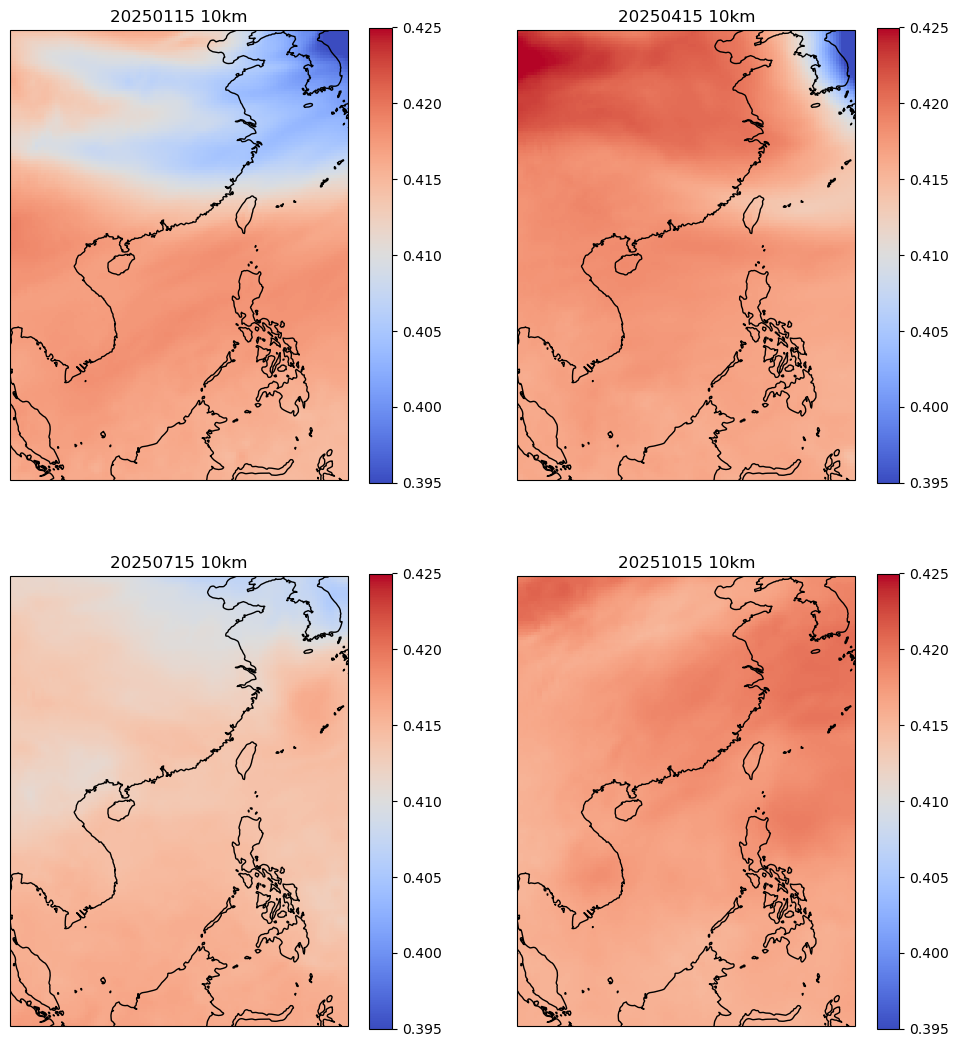

In [74]:
x,y = era20250115.locGrid()
fig = plt.figure(figsize=(12,13))
axs = []
for i,MH in enumerate([M01H10,M04H10,M07H10,M10H10]):
    axs.append(fig.add_subplot(221+i,projection=ccrs.PlateCarree()))
    axs[i].add_feature(cfeature.COASTLINE)
    pm = axs[i].pcolormesh(y.T,x.T,MH,vmin=0.395,vmax=0.425,cmap = 'coolwarm')
    fig.colorbar(pm)

axs[0].set_title('20250115 10km')
axs[1].set_title('20250415 10km')
axs[2].set_title('20250715 10km')
axs[3].set_title('20251015 10km')